# MNIST from Scratch

## Import Libraries

Libraries that I'm using to do this work: 
1. Numpy to facilitate Matrix Multiplication operations
2. Keras to use their datasets to load the MNIST dataset
3. Matplotlib to visualize the dataset
4. Shuffle {TODO}

In [291]:
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt
from random import shuffle

np.random.seed(3)

## Load MNIST dataset

In [292]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [293]:
print(f"Type of X_train: {type(X_train)}")
print(f"Type of y_train: {type(y_train)}")
print(f"Type of X_test: {type(X_test)}")
print(f"Type of y_test: {type(y_test)}")

Type of X_train: <class 'numpy.ndarray'>
Type of y_train: <class 'numpy.ndarray'>
Type of X_test: <class 'numpy.ndarray'>
Type of y_test: <class 'numpy.ndarray'>


In [294]:
print(f"Train features shape: {X_train.shape}")
print(f"Train targets shape: {y_train.shape}")
print(f"Test features shape: {X_test.shape}")
print(f"Test targets shape: {y_test.shape}")

Train features shape: (60000, 28, 28)
Train targets shape: (60000,)
Test features shape: (10000, 28, 28)
Test targets shape: (10000,)


As you can see from the output of the above cell, the MNIST dataset in its entirety is structured in the following way:
 - Training Dataset: 60000, 28, 28
   - 60000: the number of images in the training set
   - 28 x 28: each image measures 28 x 28 pixel. 
 - Testing Dataset: 10000, 28, 28
   - 10000: the number of images in the testing set
   - 28 x 28: each image measures 28 x 28 pixel. 

In its entirety, the MNIST dataset has (60,000 training images + 10,000 testing images) 70,000 images.

Let's visualize this data

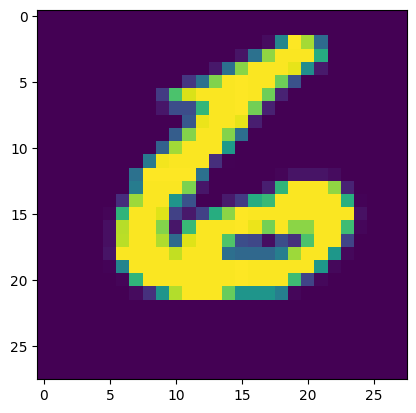

In [295]:
plt.imshow(X_test[9999])

Given the above image, its corresponding label is shown below. 

Changing the index in both the above and the below line of code should display other images and its corresponding label. Keep in mind, if you're indexing the `X_train` and `y_train` variables, the valid indices are between `0-59999`. 

Likewise, if you're indexing `X_test` and `y_test`, valid indices are between `0-9999`


In [296]:
y_test[9999]

np.uint8(6)

Let's flatten the images so that they're not 3-dimensional but instead 2-dimensional in order for them to be ingested by the Network we'll create


In [297]:
X_train_flattened = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2])
print(f"X_train_flattened shape: {X_train_flattened.shape}")
X_test_flattened = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])
print(f"X_test_flattened shape: {X_test_flattened.shape}")

X_train_flattened shape: (60000, 784)
X_test_flattened shape: (10000, 784)


Let's normalize our inputs from a value between `0-255` to a value between `0-1`. For example, a pixel value that is `159` before normalization is set to `0.6235` after normalization

In [298]:
# Before normalization
X_train_flattened[1][130]

np.uint8(159)

In [299]:
X_train_flattened = X_train_flattened / 255.0
X_test_flattened = X_test_flattened / 255.0

print(X_train_flattened.shape)
print(X_test_flattened.shape)


(60000, 784)
(10000, 784)


In [300]:
# After normalization
X_train_flattened[1][130]

np.float64(0.6235294117647059)

In [301]:
X_train = X_train_flattened
X_val = X_test_flattened

print(X_train.shape)
print(X_val.shape)

(60000, 784)
(10000, 784)


## Network
### Fully Connected Layer (Linear/Dense Layer)

In [302]:
class Linear():
    def __init__(self, in_size, out_size):
        self.name = "Linear"
        self.W = np.random.randn(in_size, out_size) * 0.01
        self.b = np.zeros((1, out_size))
        self.params = [self.W, self.b]
        self.gradW = None
        self.gradB = None
        self.gradInput = None

    def forward(self, X):
        self.X = X
        self.output = np.dot(X, self.W) + self.b
        return self.output

    def backward(self, nextgrad):
        self.gradW = np.dot(self.X.T, nextgrad)
        self.gradB = np.sum(nextgrad, axis=0)
        self.gradInput = np.dot(nextgrad, self.W.T)
        return self.gradInput, [self.gradW, self.gradB]

#### Rectified Linear Activation Layer (ReLU)


In [303]:
class ReLU():
    def __init__(self):
        self.name = "ReLU"
        self.params = []
        self.gradInput = None

    def forward(self, X):
        self.output = np.maximum(X, 0)
        return self.output

    def backward(self, nextgrad):
        self.gradInput = nextgrad.copy()
        self.gradInput[self.output <=0] = 0
        return self.gradInput, []

#### Defining the softmax function

In [304]:
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    out= exp_x / np.sum(exp_x, axis=1, keepdims=True)
    return out

#### Defining the Cross Entropy Loss

In [305]:
class CrossEntropy:
    def forward(self, X, y):
        self.m = y.shape[0]
        self.p = softmax(X)
        cross_entropy = -np.log(self.p[range(self.m), y])
        loss = cross_entropy[0] / self.m
        return loss
    
    def backward(self, X, y):
        y_idx = y.argmax()        
        grad = softmax(X)
        grad[range(self.m), y] -= 1
        grad /= self.m
        return grad

#### Here, we define the container NN class that enables the forward prop and backward propagation of the entire network. Note, how this class enables us to add layers of different types and also correctly pass gradients using the chain rule.

In [306]:
class NN():
    def __init__(self, lossfunc=CrossEntropy()):
        self.params = []
        self.layers = []
        self.loss_func = lossfunc
        self.grads = []
        
    def add_layer(self, layer):
        self.layers.append(layer)
        self.params.append(layer.params)

    def forward(self, X):
        for layer in self.layers:
            X = layer.forward(X)
        return X
    
    def backward(self, nextgrad):
        self.clear_grad_param()
        for layer in reversed(self.layers):
            nextgrad, grad = layer.backward(nextgrad)
            self.grads.append(grad)
        return self.grads
    
    def train_step(self, X, y):
        out = self.forward(X)
        loss = self.loss_func.forward(out, y)
        nextgrad = self.loss_func.backward(out, y)
        l2 = self.backward(nextgrad)
        return loss, l2
    
    def predict(self, X):
        X = self.forward(X)
        return np.argmax(X, axis=1)
    
    def predict_scores(self, X):
        X = self.forward(X)
        return X
    
    def clear_grad_param(self):
        self.grads = []

    def display(self):
        for layer in self.layers:
            if layer.name == "Linear":
                print(f"{layer.name}")
                print(f"W shape: {layer.W.shape}")
                print(f"b shape: {layer.b.shape}")
                print("------")
            else:
                print(f"{layer.name}")
                print("------")

#### Defining the update function (SGD with momentum)

In [307]:
def update_params(velocity, params, grads, learning_rate=0.01, mu=0.9):
    for v, p, g, in zip(velocity, params, reversed(grads)):
        for i in range(len(g)):
            v[i] = mu * v[i] + learning_rate * g[i]
            p[i] -= v[i]
            # print('Max gradient value:',np.amax(v[i]))
            # print('Gradient shape:',v[i].shape)

#### Defining a function which gives us the minibatches (both the datapoint and the corresponding label)

In [308]:
# get minibatches
def minibatch(X, y, minibatch_size):
    '''
    This function is used to get the minibatches of the data.
    It takes the data and the minibatch size as input and shuffles the data, which it then splits into minibatches.
    It returns the minibatches.
    '''
    n = X.shape[0]
    minibatches = []
    permutation = np.random.permutation(X.shape[0])
    X = X[permutation]
    y = y[permutation]
    
    for i in range(0, n , minibatch_size):
        X_batch = X[i:i + minibatch_size, :]
        y_batch = y[i:i + minibatch_size, ]
        minibatches.append((X_batch, y_batch))
        
    return minibatches

In [309]:
# Helper function to check the accuracy of the model
def check_accuracy(y_true, y_pred):
    return np.mean(y_pred == y_true)

#### The traning loop

In [310]:
def train(net, X_train, y_train, minibatch_size, epoch, learning_rate, mu=0.9, X_val=None, y_val=y_test):
    val_loss_epoch = []

    minibatches = minibatch(X_train, y_train, minibatch_size)
    print('Number of Minibatches:', len(minibatches))

    minibatches_val = minibatch(X_val, y_val, minibatch_size)
    print('Number of Minibatches for Validation:', len(minibatches_val))

    for i in range(epoch):
        loss_batch = []
        val_loss_batch = []
        velocity = []

        for param_layer in net.params:
            # print(f"Param layer: {param_layer}")
            p = [np.zeros_like(param) for param in list(param_layer)]
            velocity.append(p)

        # iterate over mini batches
        for X_mini, y_mini in minibatches:
            loss, grads = net.train_step(X_mini, y_mini)
            loss_batch.append(loss)
            update_params(velocity, net.params, grads, learning_rate=learning_rate, mu=mu)

        for X_mini_val, y_mini_val in minibatches_val:
            val_loss, _ = net.train_step(X_mini_val, y_mini_val)
            val_loss_batch.append(val_loss)
        
        # accuracy of model at end of epoch after all mini batch updates
        m_train = X_train.shape[0]
        m_val = X_val.shape[0]
        y_train_pred = np.array([], dtype="int64")
        y_val_pred = np.array([], dtype="int64")
        y_train1 = []
        y_vall = []
        for i in range(0, m_train, minibatch_size):
            X_tr = X_train[i:i + minibatch_size, : ]
            y_tr = y_train[i:i + minibatch_size,]
            y_train1 = np.append(y_train1, y_tr)
            y_train_pred = np.append(y_train_pred, net.predict(X_tr))

        for i in range(0, m_val, minibatch_size):
            X_va = X_val[i:i + minibatch_size, : ]
            y_va = y_val[i:i + minibatch_size,]
            y_vall = np.append(y_vall, y_va)
            y_val_pred = np.append(y_val_pred, net.predict(X_va))
            
        train_acc = check_accuracy(y_train1, y_train_pred)
        val_acc = check_accuracy(y_vall, y_val_pred)

        mean_train_loss = sum(loss_batch) / float(len(loss_batch))
        mean_val_loss = sum(val_loss_batch) / float(len(val_loss_batch))
        
        val_loss_epoch.append(mean_val_loss)
        print("Loss = {0} | Training Accuracy = {1} | Val Loss = {2} | Val Accuracy = {3}".format(mean_train_loss, train_acc, mean_val_loss, val_acc))
    return net, val_loss_epoch

#### Invoking all that we have created until now

In [311]:
## input size
input_dim = X_train.shape[1]

## hyperparameters
iterations = 10
learning_rate = 0.1
hidden_nodes = 64
hidden_nodes_2 = 32
output_nodes = 10

In [312]:
## define neural net
nn = NN()
nn.add_layer(Linear(input_dim, hidden_nodes))
nn.add_layer(ReLU())
nn.add_layer(Linear(hidden_nodes, hidden_nodes_2))
nn.add_layer(ReLU())
nn.add_layer(Linear(hidden_nodes_2, output_nodes))

nn.display()

Linear
W shape: (784, 64)
b shape: (1, 64)
------
ReLU
------
Linear
W shape: (64, 32)
b shape: (1, 32)
------
ReLU
------
Linear
W shape: (32, 10)
b shape: (1, 10)
------


In [313]:
nn, val_loss_epoch = train(nn, X_train , y_train, minibatch_size=200, epoch=7, \
           learning_rate=learning_rate, X_val=X_val)

Number of Minibatches: 300
Number of Minibatches for Validation: 50
Loss = 0.0054041105565968495 | Training Accuracy = 0.9359333333333333 | Val Loss = 0.0005482383589339837 | Val Accuracy = 0.9347
Loss = 0.0009680256385474392 | Training Accuracy = 0.96405 | Val Loss = 0.00037724466481972097 | Val Accuracy = 0.9604
Loss = 0.0006443721777851831 | Training Accuracy = 0.96985 | Val Loss = 0.00017887387844947307 | Val Accuracy = 0.9624
Loss = 0.0004358997475847859 | Training Accuracy = 0.9720833333333333 | Val Loss = 9.677571310238719e-05 | Val Accuracy = 0.9656
Loss = 0.0004063326489279334 | Training Accuracy = 0.9763666666666667 | Val Loss = 8.541471547449171e-05 | Val Accuracy = 0.9668
Loss = 0.00029771747357103115 | Training Accuracy = 0.9802666666666666 | Val Loss = 0.0001345036251990145 | Val Accuracy = 0.9696
Loss = 0.0002392684550648667 | Training Accuracy = 0.9837833333333333 | Val Loss = 0.00011706127692633279 | Val Accuracy = 0.9691


## Metrics


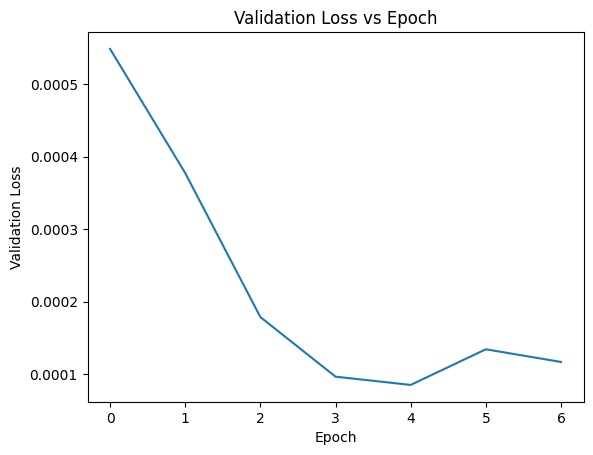

In [314]:
plt.plot(val_loss_epoch)
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss vs Epoch')
plt.show()